<a href="https://colab.research.google.com/github/PoHungWu/Individual-Projects/blob/main/Individual_Project_Earnings_Surprises_and_Market_Reactions_Peter_Wu_(Shared_version).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Project Title:**

**Earnings Surprises and Market Reactions: A Cross-Industry Regression Analysis**

## Project objective

To explore how different industries respond to earnings surprises, leveraging regression and correlation analyses to uncover patterns that can inform investment and strategic decision-making.

## Data overview

Data Sources:
1. Stock Price Data

	•	Source: Alpha Vantage API

	•	Method: Retrieved full daily stock prices in CSV format for all 25 selected tickers via API queries. Used to compute price returns around the earnings release dates.

	•	Time Span: Covers approximately 2000 to early 2025, depending on ticker availability.

2. Earnings Data

	•	Source: AlphaQuery – Company Key Metrics

	•	Method: Manually collected actual and estimated EPS along with earnings announcement dates for 25 large-cap U.S. companies, using historical records provided on individual stock pages.

	•	Time Span: Varies by company, generally ranging from 2012 to early 2024.

3. Industry Classification

	•	Method: Manually mapped each ticker to one of five major industries: Technology, Financials, Consumer, Energy & Utilities, and Healthcare, based on standard GICS classifications.


##D1: Library and data imports

In [ ]:
!pip install pandas --quiet
!pip install yfinance --quiet

In [ ]:
import requests
import pandas as pd
import time

# Alpha Vantage API Key
Alpha_Vantage_api_key = ''

# Top 5 U.S. companies by market cap in each of the 5 major industries
symbols = [
    # Technology
    'AAPL', 'MSFT', 'NVDA', 'GOOG', 'META',
    # Energy / Utilities
    'XOM', 'CVX', 'COP', 'SO', 'DUK',
    # Financials
    'JPM', 'BAC', 'WFC', 'C', 'GS',
    # Consumer
    'AMZN', 'TSLA', 'WMT', 'HD', 'MCD',
    # Healthcare
    'UNH', 'JNJ', 'PFE', 'MRK', 'ABBV'
]

all_data = {}

for i, symbol in enumerate(symbols):
    print(f"Fetching data for {symbol}...")
    url = f'https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol={symbol}&apikey={Alpha_Vantage_api_key}&outputsize=full&datatype=csv'

    try:
        df = pd.read_csv(url)
        all_data[symbol] = df
        print(df.head(), "\n")  # Preview first few rows
    except Exception as e:
        print(f"Failed to fetch {symbol}: {e}")

    # Safer sleep interval to avoid hitting rate limit
    if (i + 1) % 5 == 0:
        print("⏳ Waiting 70 seconds to respect API limit...")
        time.sleep(70)
    else:
        time.sleep(15)

Fetching data for AAPL...
    timestamp    open      high       low   close    volume
0  2025-05-09  199.00  200.5399  197.5350  198.53  36453923
1  2025-05-08  197.72  200.0500  194.6796  197.49  50478872
2  2025-05-07  199.17  199.4400  193.2500  196.25  68616943
3  2025-05-06  198.21  200.6500  197.0200  198.51  51216482
4  2025-05-05  203.10  204.1000  198.2100  198.89  69018452 

Fetching data for MSFT...
    timestamp    open    high       low   close    volume
0  2025-05-09  440.00  440.74  435.8800  438.73  15324233
1  2025-05-08  437.93  443.67  435.6600  438.17  23491330
2  2025-05-07  433.84  438.12  431.1103  433.35  23307241
3  2025-05-06  432.20  437.73  431.1700  433.31  15104204
4  2025-05-05  432.87  439.50  432.1100  436.17  20136053 

Fetching data for NVDA...
    timestamp     open     high       low   close     volume
0  2025-05-09  117.350  118.230  115.2100  116.65  132972189
1  2025-05-08  118.250  118.680  115.8500  117.37  198428122
2  2025-05-07  113.045  117

In [ ]:
for symbol, df in all_data.items():
    df.to_csv(f"{symbol}_daily.csv", index=False)

In [ ]:
import zipfile
import os

zip_filename = "stock_data.zip"
with zipfile.ZipFile(zip_filename, 'w') as zipf:
    for symbol in all_data:
        filename = f"{symbol}_daily.csv"
        zipf.write(filename)

from google.colab import files
files.download(zip_filename)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving earnings_data.xlsx to earnings_data.xlsx


##D2. Data pre-processing

In [ ]:
excel_path = 'earnings_data.xlsx'
earnings_sheets = pd.read_excel(excel_path, sheet_name=None)

print("Available sheets:", earnings_sheets.keys())

Available sheets: dict_keys(['AAPL', 'MSFT', 'NVDA', 'GOOG', 'META', 'XOM', 'CVX', 'COP', 'SO', 'DUK', 'JPM', 'BAC', 'WFC', 'C', 'GS', 'AMZN', 'TSLA', 'WMT', 'HD', 'MCD', 'UNH', 'JNJ', 'PFE', 'MRK', 'ABBV'])


In [ ]:
from datetime import datetime

# Function to process one company's data
def process_company(symbol, earnings_df, price_df):
    earnings_df['Estimated EPS'] = pd.to_numeric(earnings_df['Estimated EPS'], errors='coerce')
    earnings_df['Actual EPS'] = pd.to_numeric(earnings_df['Actual EPS'], errors='coerce')
    earnings_df['release_date'] = pd.to_datetime(earnings_df['Announcement Date'])
    earnings_df['surprise_percent'] = ((earnings_df['Actual EPS'] - earnings_df['Estimated EPS']) / earnings_df['Estimated EPS']) * 100

    price_df['timestamp'] = pd.to_datetime(price_df['timestamp'])
    price_df = price_df[['timestamp', 'close']]

    results = []
    for _, row in earnings_df.iterrows():
        t = row['release_date']
        t_minus_1 = price_df[price_df['timestamp'] < t].sort_values('timestamp', ascending=False).head(1)
        t_plus_1 = price_df[price_df['timestamp'] > t].sort_values('timestamp', ascending=True).head(1)

        if not t_minus_1.empty and not t_plus_1.empty:
            price_t_minus_1 = t_minus_1['close'].values[0]
            price_t_plus_1 = t_plus_1['close'].values[0]
            ret = (price_t_plus_1 - price_t_minus_1) / price_t_minus_1 * 100
        else:
            ret = None

        results.append({
            'release_date': t.date(),
            'surprise_percent': row['surprise_percent'],
            'return_%': ret
        })

    return pd.DataFrame(results)

In [ ]:
jpm_earnings_df = earnings_sheets['JPM']

jpm_price_df = pd.read_csv('JPM_daily.csv')

jpm_result_df = process_company('JPM', jpm_earnings_df, jpm_price_df)

jpm_result_df.head()

,release_date,surprise_percent,return_%
0,2025-04-11,9.740260,3.350799
1,2025-01-15,19.354839,2.747808
2,2024-10-11,8.706468,4.059387
3,2024-07-12,5.011933,1.253314
4,2024-04-12,10.765550,-6.416620


In [ ]:
from google.colab import files

all_company_results = []

# Process each sheet (i.e., each company)
for symbol in earnings_sheets.keys():
    print(f"Processing {symbol}...")

    earnings_df = earnings_sheets[symbol]
    stock_file = f"{symbol}_daily.csv"

    if os.path.exists(stock_file):
        stock_df = pd.read_csv(stock_file)
        try:
            # Clean EPS columns BEFORE processing
            earnings_df['Estimated EPS'] = pd.to_numeric(earnings_df['Estimated EPS'], errors='coerce')
            earnings_df['Actual EPS'] = pd.to_numeric(earnings_df['Actual EPS'], errors='coerce')

            result_df = process_company(symbol, earnings_df, stock_df)
            result_df['ticker'] = symbol
            all_company_results.append(result_df)
        except Exception as e:
            print(f" Error processing {symbol}: {e}")
    else:
        print(f" Stock file not found for {symbol}: {stock_file}")

# Merge all into a single DataFrame
all_results_df = pd.concat(all_company_results, ignore_index=True)

print("Finished processing all companies. Here's a preview:")
print(all_results_df.head())

all_results_df.to_csv("all_25_companies_result.csv", index=False)
files.download("all_25_companies_result.csv")

Processing AAPL...
Processing MSFT...
Processing NVDA...
Processing GOOG...
Processing META...
Processing XOM...
Processing CVX...
Processing COP...
Processing SO...
Processing DUK...
Processing JPM...
Processing BAC...
Processing WFC...
Processing C...
Processing GS...
Processing AMZN...
Processing TSLA...
Processing WMT...
Processing HD...
Processing MCD...
Processing UNH...
Processing JNJ...
Processing PFE...
Processing MRK...
Processing ABBV...
Finished processing all companies. Here's a preview:
  release_date  surprise_percent  return_% ticker
0   2025-05-01          2.484472 -3.364706   AAPL
1   2025-01-30          1.694915 -1.403743   AAPL
2   2024-10-31         10.067114 -3.124728   AAPL
3   2024-08-01          4.477612 -0.999640   AAPL
4   2024-05-02          1.324503  8.316598   AAPL


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
industry_map = {
    # Technology
    'AAPL': 'Technology', 'MSFT': 'Technology', 'NVDA': 'Technology', 'GOOG': 'Technology', 'META': 'Technology',
    # Energy & Utilities
    'XOM': 'Energy & Utilities', 'CVX': 'Energy & Utilities', 'COP': 'Energy & Utilities',
    'SO': 'Energy & Utilities', 'DUK': 'Energy & Utilities',
    # Financials
    'JPM': 'Financials', 'BAC': 'Financials', 'WFC': 'Financials', 'C': 'Financials', 'GS': 'Financials',
    # Consumer
    'AMZN': 'Consumer', 'TSLA': 'Consumer', 'WMT': 'Consumer', 'HD': 'Consumer', 'MCD': 'Consumer',
    # Healthcare
    'UNH': 'Healthcare', 'JNJ': 'Healthcare', 'PFE': 'Healthcare', 'MRK': 'Healthcare', 'ABBV': 'Healthcare'
}

all_results_df['industry'] = all_results_df['ticker'].map(industry_map)

print(all_results_df[['ticker', 'industry']].drop_duplicates().sort_values(by='industry').reset_index(drop=True))

   ticker            industry
0     WMT            Consumer
1    AMZN            Consumer
2      HD            Consumer
3     MCD            Consumer
4    TSLA            Consumer
5     DUK  Energy & Utilities
6     COP  Energy & Utilities
7      SO  Energy & Utilities
8     XOM  Energy & Utilities
9     CVX  Energy & Utilities
10    JPM          Financials
11    BAC          Financials
12      C          Financials
13     GS          Financials
14    WFC          Financials
15    UNH          Healthcare
16    JNJ          Healthcare
17    PFE          Healthcare
18   ABBV          Healthcare
19    MRK          Healthcare
20   META          Technology
21   GOOG          Technology
22   NVDA          Technology
23   MSFT          Technology
24   AAPL          Technology


##D3. Data analysis

### Question 1

What is the relationship between EPS surprise and short-term stock return across different industries?

####Answer

There is a modest positive relationship between EPS surprises and short-term stock returns, with variation across industries. **The effect is most evident in the Technology sector**, while other sectors like Healthcare and Financials show limited responsiveness.

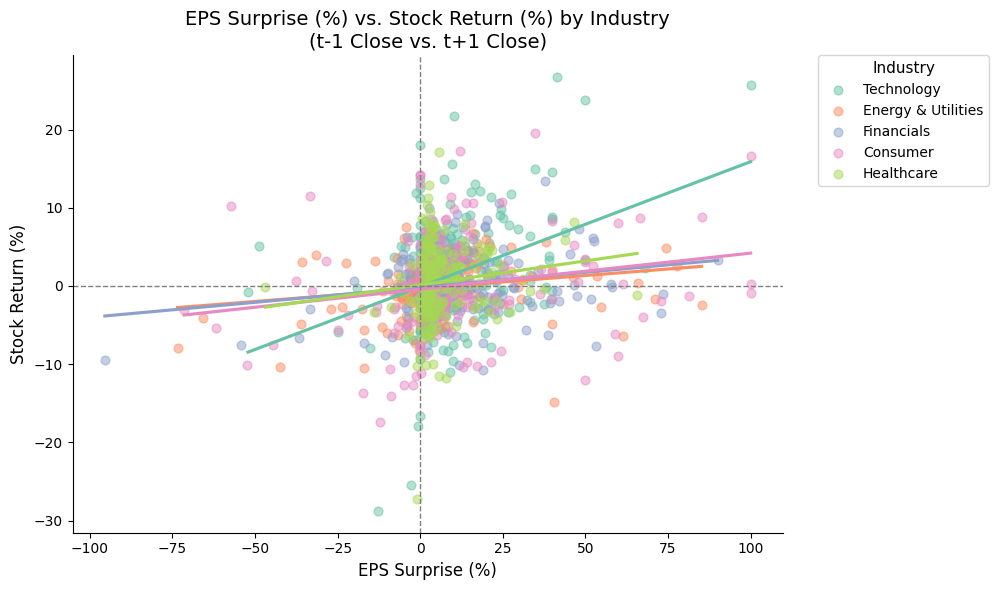

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

clean_df = all_results_df.dropna(subset=['surprise_percent', 'return_%'])

filtered_df = clean_df[
    (clean_df['surprise_percent'].between(-100, 100)) &
    (clean_df['return_%'].between(-100, 100))
]

g = sns.lmplot(
    data=filtered_df,
    x='surprise_percent',
    y='return_%',
    hue='industry',
    palette='Set2',
    scatter_kws={'alpha': 0.5, 's': 40},
    height=6,
    aspect=1.4,
    ci=None
)

plt.title("EPS Surprise (%) vs. Stock Return (%) by Industry\n(t-1 Close vs. t+1 Close)", fontsize=14)
plt.xlabel("EPS Surprise (%)", fontsize=12)
plt.ylabel("Stock Return (%)", fontsize=12)

plt.axhline(0, color='gray', linestyle='--', linewidth=1)
plt.axvline(0, color='gray', linestyle='--', linewidth=1)

if g._legend is not None:
    g._legend.remove()

plt.legend(title='Industry', bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0., fontsize=10, title_fontsize=11)
plt.tight_layout()
plt.show()

In [ ]:
filtered_df = filtered_df[
    (filtered_df['surprise_percent'].between(-100, 100)) &
    (filtered_df['return_%'].between(-100, 100))
]

correlation_by_industry = (
    filtered_df[['industry', 'surprise_percent', 'return_%']]
    .groupby('industry')
    .apply(lambda g: g['surprise_percent'].corr(g['return_%']))
    .reset_index(name='correlation')
).dropna().sort_values(by='correlation', ascending=False)

print(correlation_by_industry)

             industry  correlation
4          Technology     0.348314
1  Energy & Utilities     0.190314
0            Consumer     0.187585
2          Financials     0.179185
3          Healthcare     0.123510


<ipython-input-13-a7b4a1c253d4>:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g['surprise_percent'].corr(g['return_%']))


<ipython-input-14-e242c313ffea>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


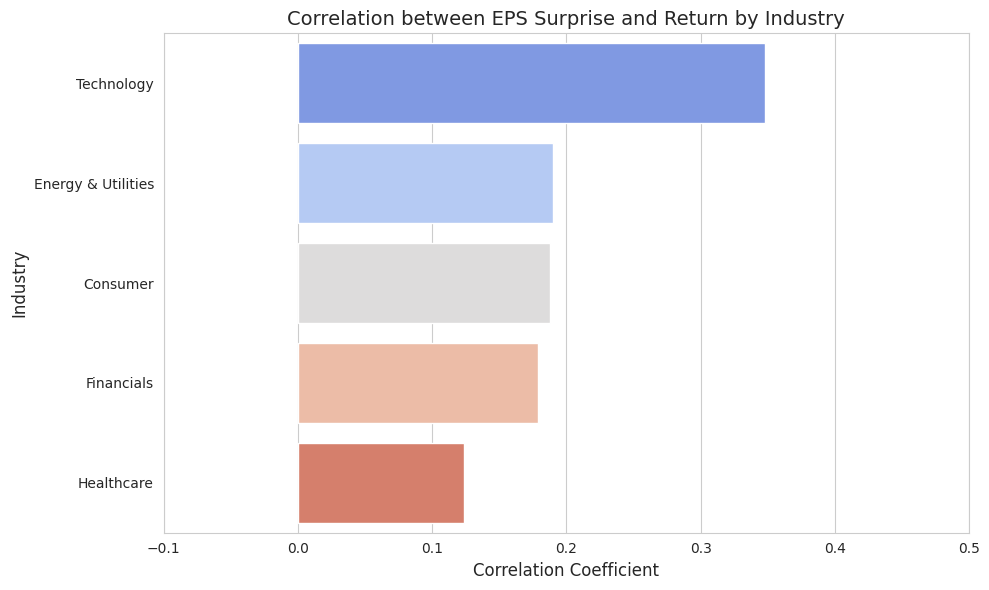

In [ ]:
plt.figure(figsize=(10, 6))
sns.set_style("whitegrid")

sns.barplot(
    data=correlation_by_industry,
    x="correlation",
    y="industry",
    palette="coolwarm",
    orient="h"
)

plt.title("Correlation between EPS Surprise and Return by Industry", fontsize=14)
plt.xlabel("Correlation Coefficient", fontsize=12)
plt.ylabel("Industry", fontsize=12)
plt.xlim(-0.1, 0.5)

plt.tight_layout()
plt.show()

### Question 2

How does the strength and statistical significance of the relationship between EPS surprise and short-term stock return vary across different industries?

####Answer

The impact of EPS surprise on short-term stock return varies notably across industries.

**The Technology sector shows the strongest and most statistically significant relationship** (coefficient ≈ 0.16, p < 0.001), while other industries such as Consumer, Financials, and Energy & Utilities exhibit modest but still significant effects (p < 0.01).

**In contrast, Healthcare’s relationship is not statistically significant**, suggesting that earnings surprises in that sector may be less influential in driving immediate price movements.

In [ ]:
import statsmodels.api as sm

industry_results = {}

for industry, group in filtered_df.groupby('industry'):
    X = sm.add_constant(group['surprise_percent'])
    y = group['return_%']
    model = sm.OLS(y, X).fit()
    industry_results[industry] = model

print(industry_results['Technology'].summary())

                            OLS Regression Results                            
Dep. Variable:               return_%   R-squared:                       0.121
Model:                            OLS   Adj. R-squared:                  0.117
Method:                 Least Squares   F-statistic:                     26.10
Date:                Sun, 11 May 2025   Prob (F-statistic):           7.90e-07
Time:                        21:15:22   Log-Likelihood:                -641.69
No. Observations:                 191   AIC:                             1287.
Df Residuals:                     189   BIC:                             1294.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -0.1169      0.614  

In [ ]:
print(industry_results['Energy & Utilities'].summary())

                            OLS Regression Results                            
Dep. Variable:               return_%   R-squared:                       0.036
Model:                            OLS   Adj. R-squared:                  0.031
Method:                 Least Squares   F-statistic:                     7.441
Date:                Sun, 11 May 2025   Prob (F-statistic):            0.00695
Time:                        21:15:24   Log-Likelihood:                -522.17
No. Observations:                 200   AIC:                             1048.
Df Residuals:                     198   BIC:                             1055.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -0.3209      0.245  

In [ ]:
print(industry_results['Financials'].summary())

                            OLS Regression Results                            
Dep. Variable:               return_%   R-squared:                       0.032
Model:                            OLS   Adj. R-squared:                  0.027
Method:                 Least Squares   F-statistic:                     6.867
Date:                Sun, 11 May 2025   Prob (F-statistic):            0.00943
Time:                        21:15:25   Log-Likelihood:                -582.68
No. Observations:                 209   AIC:                             1169.
Df Residuals:                     207   BIC:                             1176.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -0.1740      0.317  

In [ ]:
print(industry_results['Consumer'].summary())

                            OLS Regression Results                            
Dep. Variable:               return_%   R-squared:                       0.035
Model:                            OLS   Adj. R-squared:                  0.030
Method:                 Least Squares   F-statistic:                     6.966
Date:                Sun, 11 May 2025   Prob (F-statistic):            0.00899
Time:                        21:15:27   Log-Likelihood:                -617.04
No. Observations:                 193   AIC:                             1238.
Df Residuals:                     191   BIC:                             1245.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -0.4133      0.458  

In [ ]:
print(industry_results['Healthcare'].summary())

                            OLS Regression Results                            
Dep. Variable:               return_%   R-squared:                       0.015
Model:                            OLS   Adj. R-squared:                  0.010
Method:                 Least Squares   F-statistic:                     3.191
Date:                Sun, 11 May 2025   Prob (F-statistic):             0.0755
Time:                        21:15:28   Log-Likelihood:                -619.60
No. Observations:                 208   AIC:                             1243.
Df Residuals:                     206   BIC:                             1250.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.1510      0.393  

<ipython-input-20-355d6059ee06>:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=summary_df, x='Coefficient', y='Industry', palette='Blues_r')
<ipython-input-20-355d6059ee06>:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=summary_df, x='P_value', y='Industry', palette='Reds_r')


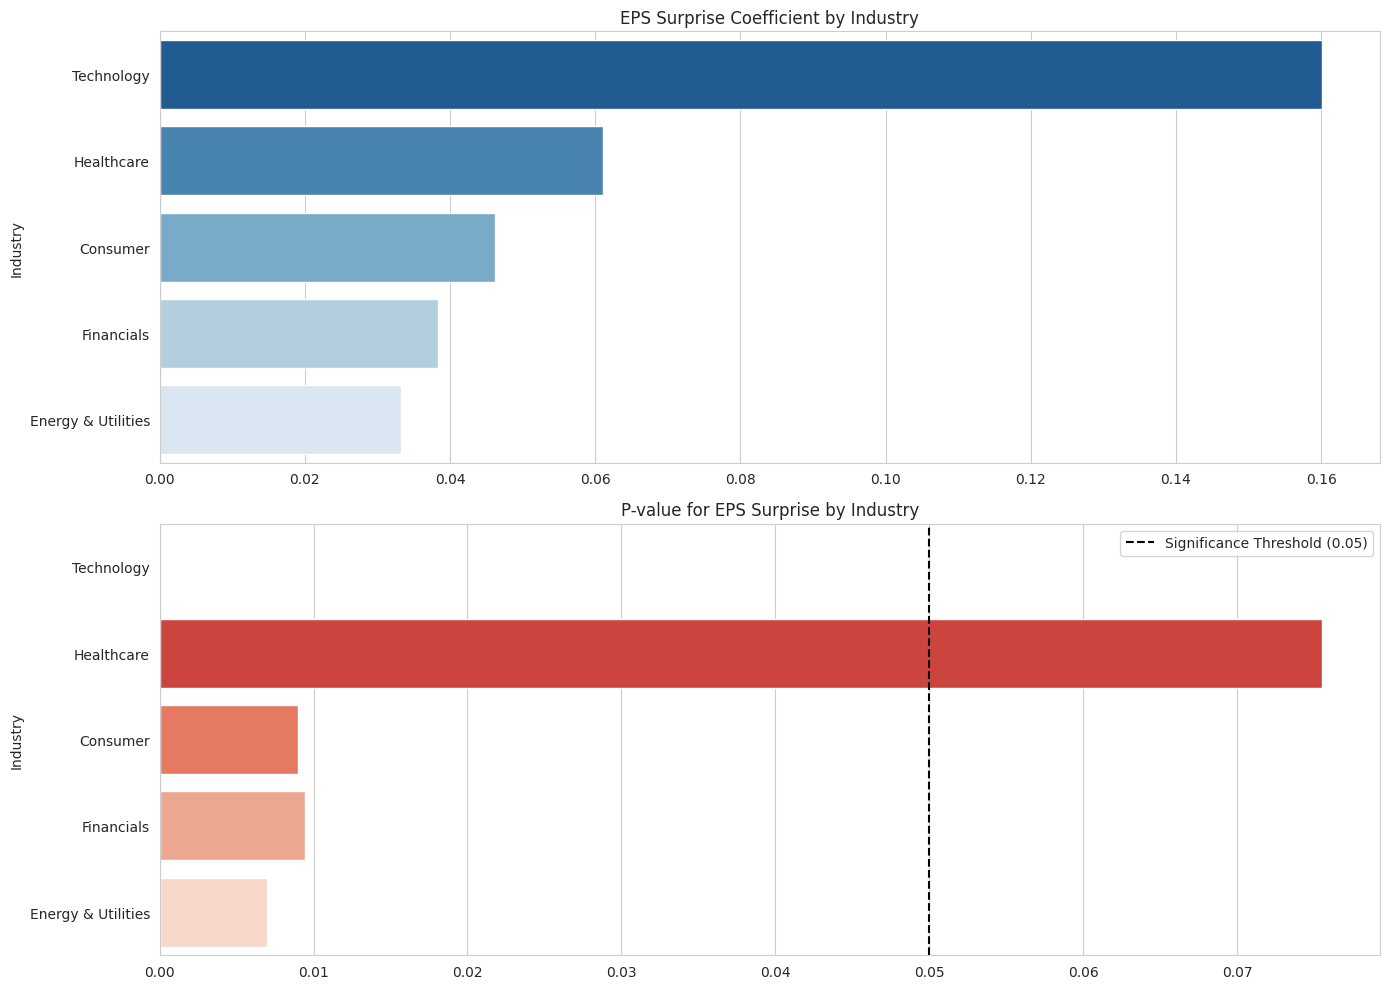

In [ ]:
summary_data = []

for industry, model in industry_results.items():
    coef = model.params['surprise_percent']
    r2 = model.rsquared
    pval = model.pvalues['surprise_percent']
    summary_data.append({
        'Industry': industry,
        'Coefficient': coef,
        'R_squared': r2,
        'P_value': pval
    })

summary_df = pd.DataFrame(summary_data).sort_values(by='Coefficient', ascending=False)

plt.figure(figsize=(14, 10))
sns.set_style("whitegrid")

# Plot 1: Coefficients
plt.subplot(2, 1, 1)
sns.barplot(data=summary_df, x='Coefficient', y='Industry', palette='Blues_r')
plt.axvline(0, color='gray', linestyle='--')
plt.title('EPS Surprise Coefficient by Industry')
plt.xlabel('')

# Plot 2: P-values
plt.subplot(2, 1, 2)
sns.barplot(data=summary_df, x='P_value', y='Industry', palette='Reds_r')
plt.axvline(0.05, color='black', linestyle='--', label='Significance Threshold (0.05)')
plt.legend()
plt.title('P-value for EPS Surprise by Industry')
plt.xlabel('')

plt.tight_layout()
plt.show()

###Question 3

How does the impact of EPS surprise on short-term stock returns vary across industries and between pre- and post-2020 periods?

####Answer

The responsiveness of stock returns to EPS surprises differs by industry, with Technology firms exhibiting the largest incremental effect: a 1% EPS surprise is associated with an additional 0.116% return compared to Consumer stocks (p < 0.001). In contrast, other sectors such as Financials and Energy & Utilities show negligible or statistically insignificant differences, and no meaningful shift is observed between pre- and post-2020 periods.

In [ ]:
filtered_df['release_date'] = pd.to_datetime(filtered_df['release_date'])
filtered_df['period'] = filtered_df['release_date'].apply(lambda x: 'pre_2020' if x.year < 2020 else 'post_2020')

In [ ]:
filtered_df = filtered_df.rename(columns={'return_%': 'return_pct'})

filtered_df['period'] = filtered_df['release_date'].apply(lambda x: 'pre_2020' if x.year < 2020 else 'post_2020')

import statsmodels.formula.api as smf
model = smf.ols('return_pct ~ surprise_percent + industry + period + surprise_percent:industry + surprise_percent:period', data=filtered_df).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:             return_pct   R-squared:                       0.079
Model:                            OLS   Adj. R-squared:                  0.069
Method:                 Least Squares   F-statistic:                     7.736
Date:                Sun, 11 May 2025   Prob (F-statistic):           6.06e-13
Time:                        21:17:57   Log-Likelihood:                -3051.8
No. Observations:                1001   AIC:                             6128.
Df Residuals:                     989   BIC:                             6186.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                                                      coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------

<ipython-input-26-c5a1778e117b>:32: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.barplot(data=coef_df, y='Term', x='Coefficient', palette='coolwarm', orient='h', ci=None)
<ipython-input-26-c5a1778e117b>:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=coef_df, y='Term', x='Coefficient', palette='coolwarm', orient='h', ci=None)


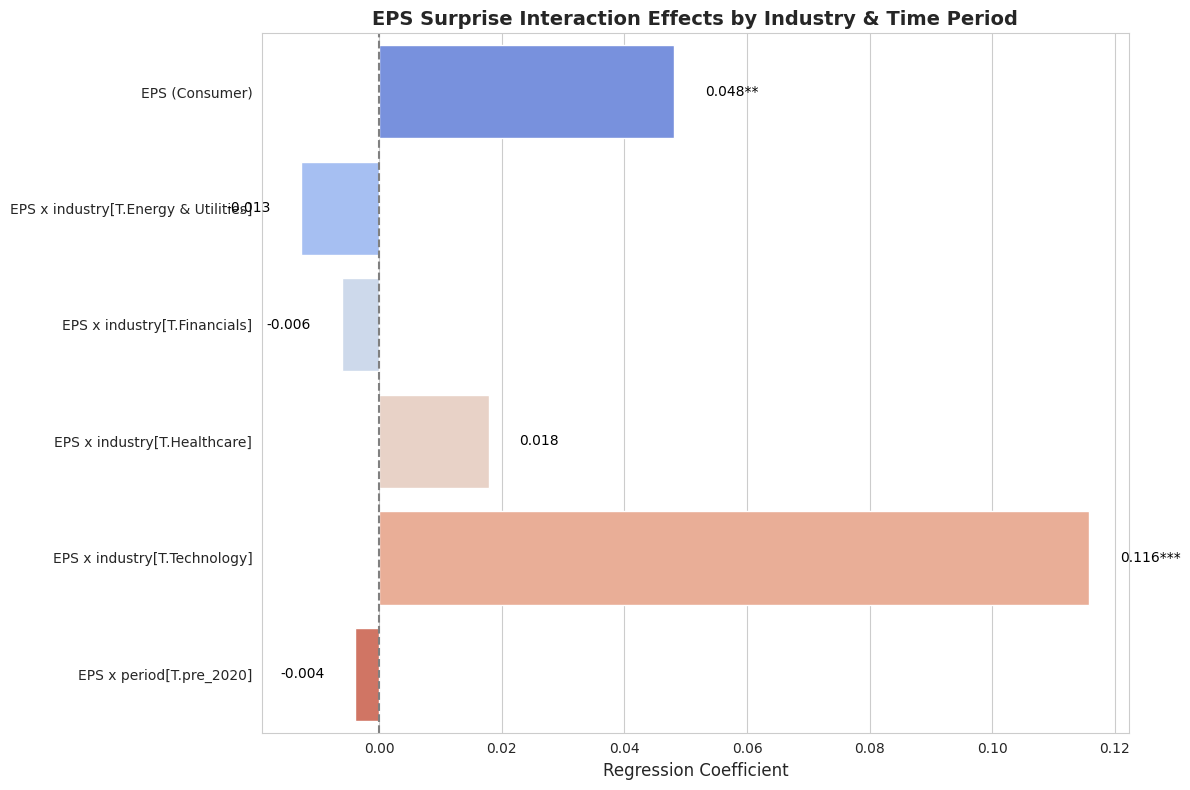

In [ ]:
coefs = model.params
pvals = model.pvalues
conf_ints = model.conf_int()

coef_df = pd.DataFrame({
    'Term': coefs.index,
    'Coefficient': coefs.values,
    'P_value': pvals.values,
    'CI_lower': conf_ints[0].values,
    'CI_upper': conf_ints[1].values
})
coef_df = coef_df[coef_df['Term'].str.contains('surprise_percent')].copy()

def significance_marker(p):
    if p < 0.001:
        return '***'
    elif p < 0.01:
        return '**'
    elif p < 0.05:
        return '*'
    else:
        return ''

coef_df['Significance'] = coef_df['P_value'].apply(significance_marker)
coef_df['Label'] = coef_df['Coefficient'].round(3).astype(str) + coef_df['Significance']
coef_df['Term'] = coef_df['Term'].str.replace('surprise_percent:', 'EPS x ').str.replace('surprise_percent', 'EPS (Consumer)').str.replace('industry\[T.', '').str.replace('period\[T.', '').str.replace('\]', '')

plt.figure(figsize=(12, 8))

sns.set_style('whitegrid')

ax = sns.barplot(data=coef_df, y='Term', x='Coefficient', palette='coolwarm', orient='h', ci=None)
plt.axvline(0, color='gray', linestyle='--')

for i, (coef, label) in enumerate(zip(coef_df['Coefficient'], coef_df['Label'])):
    ax.text(
        coef + 0.005 if coef > 0 else coef - 0.005,
        i,
        label,
        color='black',
        ha='left' if coef > 0 else 'right',
        va='center',
        fontsize=10
    )

plt.title('EPS Surprise Interaction Effects by Industry & Time Period', fontsize=14, weight='bold')
plt.xlabel('Regression Coefficient', fontsize=12)
plt.ylabel('')
plt.yticks(fontsize=10)
plt.xticks(fontsize=10)

plt.tight_layout()
plt.show()

## D4. Summary of key findings

1. **This analysis reveals a positive but modest overall relationship between EPS surprises and short-term stock returns. However, the magnitude and statistical significance of this relationship vary considerably across industries.**

<ipython-input-27-e242c313ffea>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


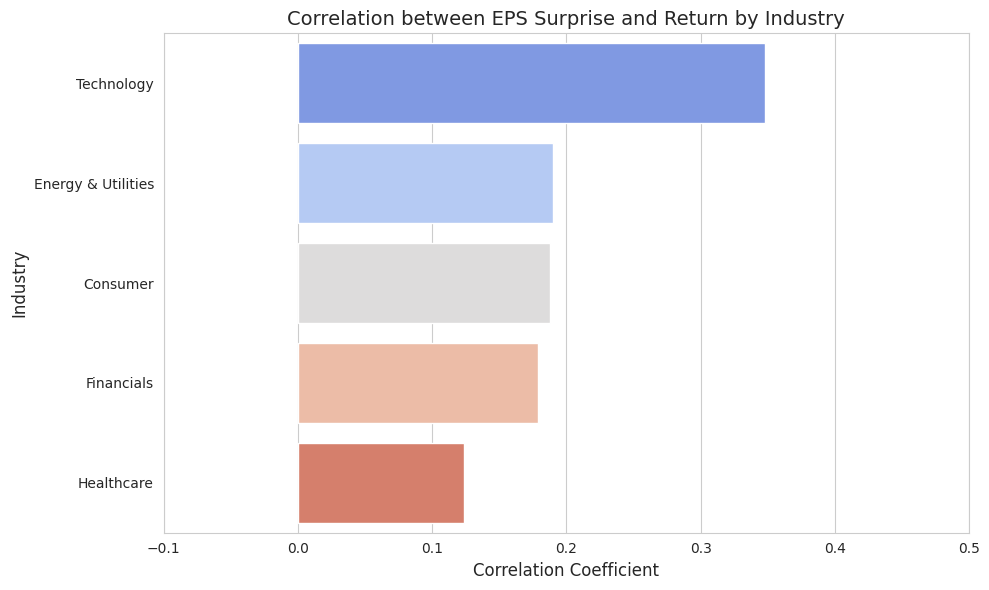

In [ ]:
plt.figure(figsize=(10, 6))
sns.set_style("whitegrid")

sns.barplot(
    data=correlation_by_industry,
    x="correlation",
    y="industry",
    palette="coolwarm",
    orient="h"
)

plt.title("Correlation between EPS Surprise and Return by Industry", fontsize=14)
plt.xlabel("Correlation Coefficient", fontsize=12)
plt.ylabel("Industry", fontsize=12)
plt.xlim(-0.1, 0.5)

plt.tight_layout()
plt.show()

2. **Technology stands out as the most responsive sector, showing the highest correlation (≈0.35) and the largest and most statistically significant EPS-return coefficient (≈0.16, p < 0.001).** Other industries like Consumer and Financials display moderate but significant sensitivity, **while Healthcare’s response is not statistically distinguishable from zero.**

<ipython-input-28-3390317388f4>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=summary_df, x='Coefficient', y='Industry', palette='Blues_r')
<ipython-input-28-3390317388f4>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=summary_df, x='P_value', y='Industry', palette='Reds_r')


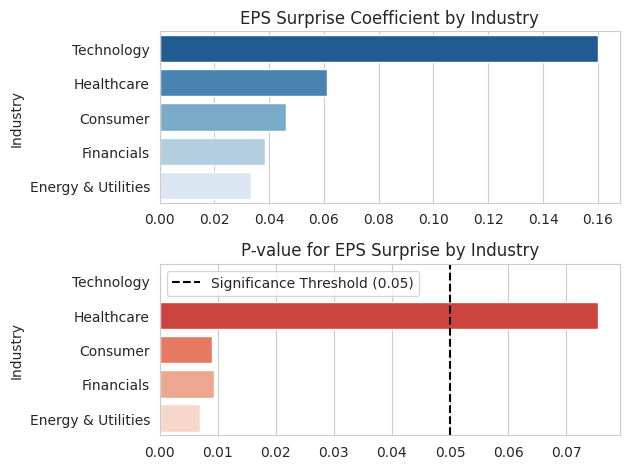

In [ ]:
# Plot 1: Coefficients
plt.subplot(2, 1, 1)
sns.barplot(data=summary_df, x='Coefficient', y='Industry', palette='Blues_r')
plt.axvline(0, color='gray', linestyle='--')
plt.title('EPS Surprise Coefficient by Industry')
plt.xlabel('')

# Plot 2: P-values
plt.subplot(2, 1, 2)
sns.barplot(data=summary_df, x='P_value', y='Industry', palette='Reds_r')
plt.axvline(0.05, color='black', linestyle='--', label='Significance Threshold (0.05)')
plt.legend()
plt.title('P-value for EPS Surprise by Industry')
plt.xlabel('')

plt.tight_layout()
plt.show()

3. Interaction analysis confirms that the EPS surprise effect is significantly stronger in the Technology sector even after controlling for time periods (pre- vs. post-2020), suggesting a robust pattern of investor reaction to earnings news in tech stocks. No notable change in EPS impact was detected between the two time periods.

<ipython-input-29-1a2bc6e1c087>:5: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.barplot(data=coef_df, y='Term', x='Coefficient', palette='coolwarm', orient='h', ci=None)
<ipython-input-29-1a2bc6e1c087>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=coef_df, y='Term', x='Coefficient', palette='coolwarm', orient='h', ci=None)


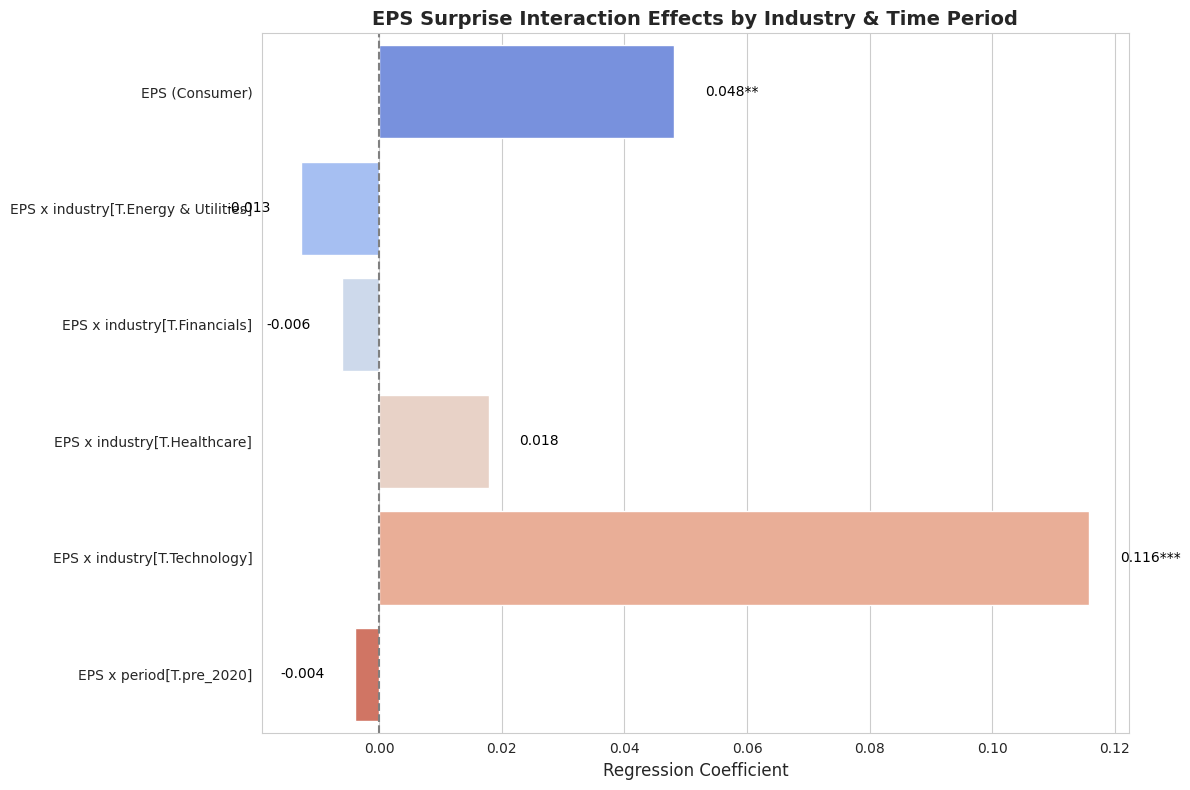

In [ ]:
plt.figure(figsize=(12, 8))

sns.set_style('whitegrid')

ax = sns.barplot(data=coef_df, y='Term', x='Coefficient', palette='coolwarm', orient='h', ci=None)
plt.axvline(0, color='gray', linestyle='--')

for i, (coef, label) in enumerate(zip(coef_df['Coefficient'], coef_df['Label'])):
    ax.text(
        coef + 0.005 if coef > 0 else coef - 0.005,
        i,
        label,
        color='black',
        ha='left' if coef > 0 else 'right',
        va='center',
        fontsize=10
    )

plt.title('EPS Surprise Interaction Effects by Industry & Time Period', fontsize=14, weight='bold')
plt.xlabel('Regression Coefficient', fontsize=12)
plt.ylabel('')
plt.yticks(fontsize=10)
plt.xticks(fontsize=10)

plt.tight_layout()
plt.show()

## D5. Further research

**1. Explore Longer-Term Price Reactions**

This study focused on short-term returns (t–1 close to t+1 close). Future research could investigate medium- to long-term price responses (e.g., 5-day, 30-day windows) to see if EPS surprises have delayed or compounding effects.

**2. Disaggregate by Firm Size or Market Capitalization**

Reactions to EPS surprises may differ between small-cap and large-cap firms. Segmenting the analysis by firm size could uncover whether market efficiency or investor behavior varies across different tiers.

**3. Incorporate Additional Earnings Call Data**

Beyond the EPS figure, investor sentiment and tone from earnings calls (e.g., via NLP on transcripts) could influence market reaction. Including qualitative signals might improve the explanatory power of models across industries.